In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch as tc
from skimage import io, color
import random
import tqdm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
! pip install torchsummary
from torchsummary import summary
import gc
from google.colab import drive
import time

In [27]:
drive.mount('/content/drive')
path = "/content/drive/My Drive/JOGA_DATASET"
path_testing = path + "/test"
path_training = path + "/train"
print(path_testing)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/JOGA_DATASET/test


In [28]:
list_train = os.listdir(path_training)
print(list_train)
list_test = os.listdir(path_testing)
print(list_test)

['plank', 'downdog', 'tree', 'warrior2', 'goddess']
['warrior2', 'goddess', 'plank', 'downdog', 'tree']


In [29]:
#Training data 
train_warrior2 = path_training + "/warrior2"
train_goddess = path_training + "/goddess"
train_downdog = path_training + "/downdog"
train_tree = path_training + "/tree"
train_plank = path_training + "/plank"

print(f'train warrior2: {len(os.listdir(train_warrior2))}')
print(f'train goddess: {len(os.listdir(train_goddess))}')
print(f'train downdog: {len(os.listdir(train_downdog))}')
print(f'train tree: {len(os.listdir(train_tree))}')
print(f'train plank: {len(os.listdir(train_plank))}')

#Testing data
test_warrior2 = path_testing + "/warrior2"
test_goddess = path_testing + "/goddess"
test_downdog = path_testing + "/downdog"
test_tree = path_testing + "/tree"
test_plank = path_testing + "/plank"

print(f'test warrior2: {len(os.listdir(test_warrior2))}')
print(f'test goddess: {len(os.listdir(test_goddess))}')
print(f'test downdog: {len(os.listdir(test_downdog))}')
print(f'test tree: {len(os.listdir(test_tree))}')
print(f'test plank: {len(os.listdir(test_plank))}')

train warrior2: 243
train goddess: 175
train downdog: 209
train tree: 155
train plank: 250
test warrior2: 103
test goddess: 76
test downdog: 90
test tree: 66
test plank: 104


In [30]:
class JogaDataset(tc.utils.data.Dataset):
  def __init__(self, image_paths, image_labels, transforms):
    self.image_paths = image_paths
    self.labels = image_labels
    self.transforms = transforms

  def __getitem__(self,i):
    image = plt.imread(self.image_paths[i])
    label = self.labels[i]
    image = self.transforms(image)
    return image, label

  def __len__(self):
    return len(self.image_paths)


def labels(filename, main_path):
    if filename[len(main_path)+1] == "w":
        label = 0
    elif filename[len(main_path)+1] == "g":
        label = 1
    elif filename[len(main_path)+1] == "d":
        label = 2
    elif filename[len(main_path)+1] == "t":
        label = 3
    else:
        label = 4
    return label

classes = ['warrior2', 'goddess', 'downdog', 'tree', 'plank']

In [31]:
paths_to_training_imgs = [path_training + '/' + i + '/' + img 
                          for i in os.listdir(path_training) 
                          for img in os.listdir(path_training + '/' + i)
                          ]

paths_to_testing_imgs = [path_testing + '/' + i + '/' + img 
                         for i in os.listdir(path_testing) 
                         for img in os.listdir(path_testing + '/' + i)
                         ]

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((224,224)),
                                #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                ])

In [32]:
label_img_train = [labels(path, path_training) for path in paths_to_training_imgs]
label_img_test = [labels(path, path_testing) for path in paths_to_testing_imgs]

print("Training:")
print(len(label_img_train))
print("Testing")
print(len(label_img_test))

Training:
1032
Testing
439


In [33]:
#Validation set 
paths_to_training_imgs , paths_to_validation_imgs, label_img_train, label_img_val = train_test_split(paths_to_training_imgs, label_img_train, test_size=0.05, random_state=10) 
print(len(paths_to_training_imgs))
print(len(paths_to_validation_imgs))

980
52


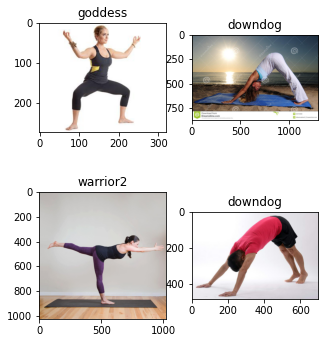

In [34]:
# random image from train Dataset (before resizing)

plt.figure(figsize=(5,6))
for i in range(4):
  n = random.randint(0, len(paths_to_training_imgs)-1)
  image = plt.imread(paths_to_training_imgs[n])
  plt.subplot(2,2,i+1)
  plt.imshow(image)
  plt.title(classes[label_img_train[n]])

plt.show()

In [35]:
batch_size = 4
num_workers = 2

all_train_dataset = JogaDataset(paths_to_training_imgs, label_img_train, transforms=transform)
all_test_dataset = JogaDataset(paths_to_testing_imgs, label_img_test, transforms=transform)
all_val_dataset = JogaDataset(paths_to_validation_imgs, label_img_val, transforms=transform)

print(len(all_train_dataset))
print(len(all_test_dataset))
print(len(all_val_dataset))

train_dataloader = DataLoader(all_train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(all_test_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(all_val_dataset, batch_size=batch_size, shuffle=True)

980
439
52


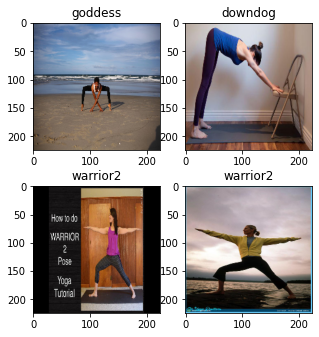

In [36]:
# random image from train DataLoader (after resizing)

plt.figure(figsize=(5,5.5))
for i in range(4):
  for images, labels in train_dataloader:
    plt.subplot(2,2,i+1)
    plt.imshow(images[i, :, :, :].numpy().swapaxes(0, 1).swapaxes(1, 2))
    plt.title(classes[labels[i]])

    break
plt.show()

In [38]:
model = torchvision.models.vgg16(pretrained=True)

device = "cuda:0"   
model = model.to(device)    
print(summary(model, input_size=(3, 224, 224)))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [39]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=10, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [40]:
optimizer = tc.optim.Adam(model.parameters(), lr=0.000001)
cost_function = nn.CrossEntropyLoss()
num_epochs = 100

early_stopping = EarlyStopping()
start = time.time()

train_losses = []
train_accuracy = []
eval_losses = []
eval_accuracy = []

for epoch in range(num_epochs):
  running_loss = 0.0
  correct = 0
  total = 0
  running_val_loss = 0.0
  correct_val = 0
  total_val = 0 
  print(f'Epoch: {epoch+1}')

  model.train()
  for image, label in tqdm.tqdm(train_dataloader, position=0, leave=True):  
    image = image.to(device)
    label = label.to(device)

    optimizer.zero_grad()
    results = model(image)
    loss = cost_function(results, label)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = results.max(1)
    total += label.size(0)
    correct += predicted.eq(label).sum().item()

  train_loss = running_loss / len(train_dataloader)
  accuracy = 100. * correct / total
  
  train_accuracy.append(accuracy)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss, accuracy))


  model.eval()
  with tc.no_grad():
    for image, label in tqdm.tqdm(validation_dataloader, position=0, leave=True):
      
      image = image.to(device)
      label = label.to(device)

      results = model(image)
      val_loss = cost_function(results, label)

      running_val_loss += val_loss.item()
      _, predicted_val = results.max(1)
      total_val += labels.size(0)
      correct_val += predicted_val.eq(label).sum().item()

  val_loss = running_val_loss / len(validation_dataloader)
  accuracy_val = 100. * correct_val / total_val

  eval_losses.append(val_loss)
  eval_accuracy.append(accuracy_val)

  print('Validation Loss: %.3f | Accuracy: %.3f'%(val_loss, accuracy_val))

  early_stopping(val_loss)
  if early_stopping.early_stop:
      break

end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

Epoch: 1


100%|██████████| 245/245 [01:48<00:00,  2.25it/s]


Train Loss: 5.808 | Accuracy: 11.633


100%|██████████| 13/13 [00:02<00:00,  6.43it/s]


Validation Loss: 3.212 | Accuracy: 21.154
Epoch: 2


100%|██████████| 245/245 [01:46<00:00,  2.30it/s]


Train Loss: 2.495 | Accuracy: 28.878


100%|██████████| 13/13 [00:02<00:00,  6.43it/s]


Validation Loss: 2.111 | Accuracy: 36.538
Epoch: 3


100%|██████████| 245/245 [01:48<00:00,  2.26it/s]


Train Loss: 1.696 | Accuracy: 47.245


100%|██████████| 13/13 [00:02<00:00,  6.50it/s]


Validation Loss: 1.638 | Accuracy: 48.077
Epoch: 4


100%|██████████| 245/245 [01:46<00:00,  2.30it/s]


Train Loss: 1.338 | Accuracy: 58.878


100%|██████████| 13/13 [00:02<00:00,  6.49it/s]


Validation Loss: 1.347 | Accuracy: 53.846
Epoch: 5


100%|██████████| 245/245 [01:49<00:00,  2.24it/s]


Train Loss: 1.103 | Accuracy: 64.694


100%|██████████| 13/13 [00:02<00:00,  6.40it/s]


Validation Loss: 1.161 | Accuracy: 65.385
Epoch: 6


100%|██████████| 245/245 [01:46<00:00,  2.29it/s]


Train Loss: 0.874 | Accuracy: 71.939


100%|██████████| 13/13 [00:02<00:00,  6.45it/s]


Validation Loss: 0.991 | Accuracy: 71.154
Epoch: 7


100%|██████████| 245/245 [01:49<00:00,  2.24it/s]


Train Loss: 0.754 | Accuracy: 76.837


100%|██████████| 13/13 [00:02<00:00,  6.44it/s]


Validation Loss: 0.909 | Accuracy: 76.923
Epoch: 8


100%|██████████| 245/245 [01:46<00:00,  2.29it/s]


Train Loss: 0.601 | Accuracy: 82.245


100%|██████████| 13/13 [00:02<00:00,  6.41it/s]


Validation Loss: 0.836 | Accuracy: 80.769
Epoch: 9


100%|██████████| 245/245 [01:49<00:00,  2.24it/s]


Train Loss: 0.524 | Accuracy: 84.082


100%|██████████| 13/13 [00:02<00:00,  6.47it/s]


Validation Loss: 0.766 | Accuracy: 84.615
Epoch: 10


100%|██████████| 245/245 [01:47<00:00,  2.29it/s]


Train Loss: 0.427 | Accuracy: 86.327


100%|██████████| 13/13 [00:02<00:00,  6.44it/s]


Validation Loss: 0.698 | Accuracy: 84.615
Epoch: 11


100%|██████████| 245/245 [01:49<00:00,  2.24it/s]


Train Loss: 0.349 | Accuracy: 89.796


100%|██████████| 13/13 [00:02<00:00,  6.42it/s]


Validation Loss: 0.677 | Accuracy: 90.385
Epoch: 12


100%|██████████| 245/245 [01:47<00:00,  2.29it/s]


Train Loss: 0.309 | Accuracy: 90.510


100%|██████████| 13/13 [00:02<00:00,  6.43it/s]


Validation Loss: 0.651 | Accuracy: 90.385
Epoch: 13


100%|██████████| 245/245 [01:49<00:00,  2.25it/s]


Train Loss: 0.263 | Accuracy: 92.041


100%|██████████| 13/13 [00:02<00:00,  6.47it/s]


Validation Loss: 0.614 | Accuracy: 90.385
Epoch: 14


100%|██████████| 245/245 [01:46<00:00,  2.29it/s]


Train Loss: 0.227 | Accuracy: 93.673


100%|██████████| 13/13 [00:02<00:00,  6.42it/s]


Validation Loss: 0.639 | Accuracy: 90.385
INFO: Early stopping counter 1 of 10
Epoch: 15


100%|██████████| 245/245 [01:49<00:00,  2.24it/s]


Train Loss: 0.202 | Accuracy: 93.571


100%|██████████| 13/13 [00:02<00:00,  6.41it/s]


Validation Loss: 0.609 | Accuracy: 90.385
Epoch: 16


100%|██████████| 245/245 [01:47<00:00,  2.29it/s]


Train Loss: 0.152 | Accuracy: 96.020


100%|██████████| 13/13 [00:02<00:00,  6.44it/s]


Validation Loss: 0.613 | Accuracy: 90.385
INFO: Early stopping counter 2 of 10
Epoch: 17


100%|██████████| 245/245 [01:49<00:00,  2.24it/s]


Train Loss: 0.133 | Accuracy: 96.429


100%|██████████| 13/13 [00:02<00:00,  6.42it/s]


Validation Loss: 0.584 | Accuracy: 90.385
Epoch: 18


100%|██████████| 245/245 [01:47<00:00,  2.29it/s]


Train Loss: 0.109 | Accuracy: 96.939


100%|██████████| 13/13 [00:02<00:00,  6.34it/s]


Validation Loss: 0.593 | Accuracy: 90.385
INFO: Early stopping counter 3 of 10
Epoch: 19


100%|██████████| 245/245 [01:49<00:00,  2.24it/s]


Train Loss: 0.101 | Accuracy: 97.449


100%|██████████| 13/13 [00:02<00:00,  6.46it/s]


Validation Loss: 0.594 | Accuracy: 90.385
INFO: Early stopping counter 4 of 10
Epoch: 20


100%|██████████| 245/245 [01:46<00:00,  2.29it/s]


Train Loss: 0.081 | Accuracy: 97.959


100%|██████████| 13/13 [00:02<00:00,  6.48it/s]


Validation Loss: 0.573 | Accuracy: 90.385
Epoch: 21


100%|██████████| 245/245 [01:49<00:00,  2.25it/s]


Train Loss: 0.069 | Accuracy: 98.061


100%|██████████| 13/13 [00:02<00:00,  6.42it/s]


Validation Loss: 0.603 | Accuracy: 90.385
INFO: Early stopping counter 5 of 10
Epoch: 22


100%|██████████| 245/245 [01:47<00:00,  2.28it/s]


Train Loss: 0.071 | Accuracy: 97.755


100%|██████████| 13/13 [00:01<00:00,  6.51it/s]


Validation Loss: 0.600 | Accuracy: 90.385
INFO: Early stopping counter 6 of 10
Epoch: 23


100%|██████████| 245/245 [01:49<00:00,  2.24it/s]


Train Loss: 0.050 | Accuracy: 98.776


100%|██████████| 13/13 [00:02<00:00,  6.42it/s]


Validation Loss: 0.594 | Accuracy: 88.462
INFO: Early stopping counter 7 of 10
Epoch: 24


100%|██████████| 245/245 [01:47<00:00,  2.29it/s]


Train Loss: 0.045 | Accuracy: 98.980


100%|██████████| 13/13 [00:02<00:00,  6.49it/s]


Validation Loss: 0.595 | Accuracy: 90.385
INFO: Early stopping counter 8 of 10
Epoch: 25


100%|██████████| 245/245 [01:49<00:00,  2.25it/s]


Train Loss: 0.038 | Accuracy: 99.286


100%|██████████| 13/13 [00:02<00:00,  6.46it/s]


Validation Loss: 0.602 | Accuracy: 90.385
INFO: Early stopping counter 9 of 10
Epoch: 26


100%|██████████| 245/245 [01:47<00:00,  2.29it/s]


Train Loss: 0.028 | Accuracy: 99.592


100%|██████████| 13/13 [00:02<00:00,  6.49it/s]

Validation Loss: 0.618 | Accuracy: 88.462
INFO: Early stopping counter 10 of 10
INFO: Early stopping
Training time: 47.710 minutes


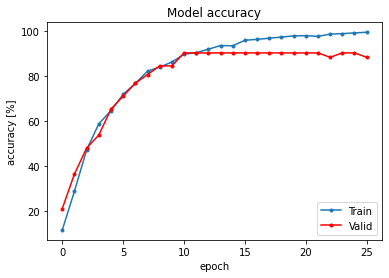

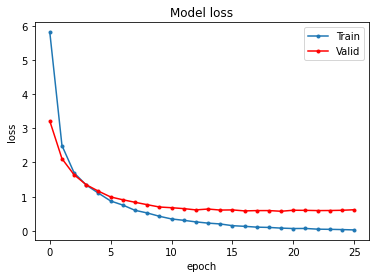

In [41]:
#plot accuracy
plt.plot(train_accuracy,'.-')
plt.plot(eval_accuracy,'r.-')
plt.xlabel('epoch')
plt.ylabel('accuracy [%]')
plt.legend(['Train','Valid'], loc="lower right")
plt.title("Model accuracy")
plt.show()

#plot losses
plt.plot(train_losses,'.-')
plt.plot(eval_losses,'r.-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title("Model loss")
plt.show()

In [42]:
true_labels = np.arange(0)
predicted_labels = np.arange(0)

amount = np.int(len(all_test_dataset)/batch_size)

for i in range(amount):                   
  test_iterator = iter(test_dataloader)
  images, labels = test_iterator.next()
  images, labels = images.cuda(), labels.cuda()

  results = model(images)
  _, predicted = tc.max(results, 1)

  labels = labels.cpu().numpy()
  predicted = predicted.cpu().numpy()
  
  true_labels = np.append(true_labels, labels)
  predicted_labels = np.append(predicted_labels,predicted)

cm=confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix : ")
print(cm)
print('Precision score: %f' % precision_score(true_labels, predicted_labels, average='macro'))
print('Accuracy score: %f' % accuracy_score(true_labels, predicted_labels))
print('F1 score: %f' % f1_score(true_labels, predicted_labels, average='macro'))
print(classification_report(true_labels, predicted_labels)) 

Confusion Matrix : 
[[100   3   0   2   0]
 [  3  69   0   0   2]
 [  0   0  87   0   0]
 [  2   0   0  48   0]
 [  2   0   4   0 114]]
Precision score: 0.958343
Accuracy score: 0.958716
F1 score: 0.958446
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       105
           1       0.96      0.93      0.95        74
           2       0.96      1.00      0.98        87
           3       0.96      0.96      0.96        50
           4       0.98      0.95      0.97       120

    accuracy                           0.96       436
   macro avg       0.96      0.96      0.96       436
weighted avg       0.96      0.96      0.96       436



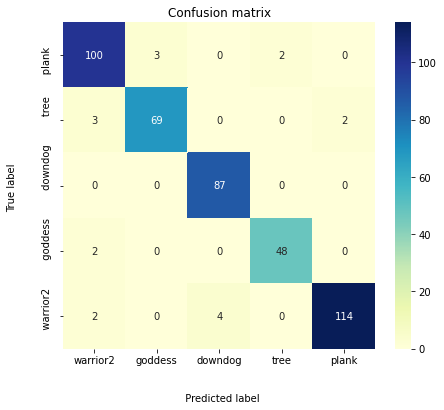

In [43]:
plt.figure(figsize=(7,6))
sns.heatmap(cm, xticklabels=classes, yticklabels=['','','','',''], annot=True, fmt='.3g',  cmap='YlGnBu')   #Reds
plt.ylabel('True label \n \n \n   warrior2         goddess         downdog         tree       plank    ')
plt.xlabel('\n \n  Predicted label')
plt.title('Confusion matrix')
plt.show()

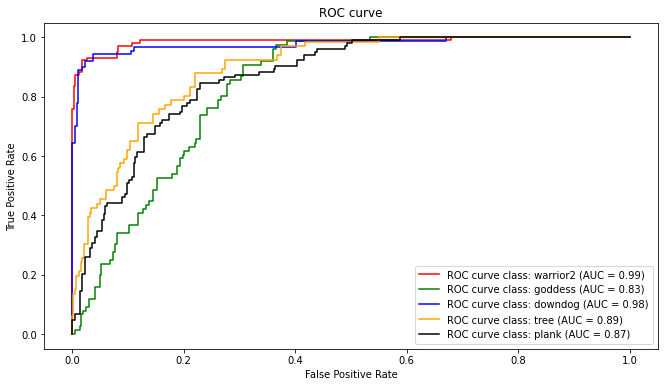

In [44]:
def class_probabilities(number_of_class):
  model.eval()
  actuals = []
  probabilities = []
  with tc.no_grad():
    for image, label in test_dataloader:
      image = image.to(device)
      label = label.to(device)
      results = model(image)
      prediction = results.argmax(dim=1, keepdim=True)
      actuals.extend(label.view_as(prediction) == number_of_class)
      probabilities.extend(np.exp(results.cpu()[:, number_of_class]))

  actuals = [i.item() for i in actuals]
  probabilities = [i.item() for i in probabilities]

  fpr, tpr, _ = roc_curve(actuals, probabilities)
  roc_auc = auc(fpr, tpr)

  return fpr, tpr, roc_auc

fpr_dict ={}
tpr_dict = {}
roc_auc_dict = {}
for i in range(5):
  fpr, tpr, roc_auc = class_probabilities(i)
  fpr_dict[i] = fpr
  tpr_dict[i] = tpr
  roc_auc_dict[i] = roc_auc

colors = ['r', 'g', 'b', 'orange', 'black']

plt.figure(figsize=[11,6])
for i in range(5):
  plt.plot(fpr_dict[i], tpr_dict[i], color = colors[i], label='ROC curve class: ' + classes[i] + ' (AUC = %0.2f)' % roc_auc_dict[i])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")

plt.show()